In [17]:
import pandas as pd

In [18]:
movies = pd.read_json("movies.json")
reviews = pd.read_json("reviews.json")

In [19]:
movies.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [20]:
reviews.head()

,user_id,item_id,rating,timestamp
0,0,50,5,1997-12-04 15:55:49
1,0,172,5,1997-12-04 15:55:49
2,0,133,1,1997-12-04 15:55:49
3,196,242,3,1997-12-04 15:55:49
4,186,302,3,1998-04-04 19:22:22


In [21]:
reviews = reviews.drop(['timestamp'], axis=1)

In [22]:
# Wrangle plan
# 1. Get the N movies that have the most reviews (reduces dimensionality and that's important when thinking about euclidean distance)
# 2. Use these top movies to cluster users based on their rating similarities
# 3. Make a recommendation based on what other users in the cluster have reviewed highly

In [15]:
# get counts of each unique movie
# Note this will take about 30 minutes
counts = []
for movie in range(1682):
    tally = 0
    for idx in range(len(reviews)):
        if reviews.iloc[idx]['item_id'] == movie:
            tally = tally + 1
    counts.append(tally)
    print("Movie " + str(movie) + " done!")

Movie 0 done!
Movie 1 done!
Movie 2 done!
Movie 3 done!
Movie 4 done!
Movie 5 done!


KeyboardInterrupt: 

In [23]:
#Let's do this instead
pivotDF = reviews.pivot(index='user_id', columns='item_id', values='rating')
pivotDF.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# Get the item_id with count
mostReviewed = 3
topN = reviews.groupby('item_id').size().sort_values(ascending=False).head(mostReviewed).reset_index()

In [85]:
topN.head()

,item_id,0
0,50,583
1,258,507
2,100,506


In [86]:
# Get a dataframe with only topN movies included
topOnlyDF = reviews[reviews["item_id"].isin(topN["item_id"])]

In [87]:
topOnlyDF.head() # Need that pivot again

,user_id,item_id,rating
0,0,50,5
53,251,100,4
188,26,258,3
267,66,258,4
378,207,258,4


In [88]:
topOnlyDF = topOnlyDF.pivot(index='user_id', columns='item_id', values='rating')

In [89]:
# People who don't review anything aren't useful to us. Let's drop them.
topOnlyDF = topOnlyDF.dropna(axis=0, how='all')

In [90]:
# The people who are left might still have NaNs. Let's fill those with a number so we can cluster!
topOnlyDF = topOnlyDF.fillna(-1)

In [91]:
topOnlyDF.head()

item_id,50,100,258
user_id,,,
0,5.0,-1.0,-1.0
1,5.0,5.0,5.0
2,5.0,5.0,3.0
3,-1.0,-1.0,2.0
4,5.0,-1.0,5.0


In [92]:
from sklearn.cluster import AgglomerativeClustering

In [93]:
agg = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agg = agg.fit(topOnlyDF)
agg.labels_

array([0, 2, 2, 3, 0, 4, 2, 2, 0, 0, 4, 1, 0, 2, 4, 0, 1, 1, 4, 3, 0, 2,
       0, 2, 1, 0, 2, 4, 2, 0, 4, 3, 3, 0, 3, 3, 4, 0, 2, 2, 4, 4, 3, 0,
       1, 1, 0, 1, 2, 2, 0, 0, 2, 4, 2, 0, 3, 2, 2, 2, 2, 0, 0, 2, 0, 4,
       4, 1, 1, 1, 1, 4, 2, 4, 1, 4, 0, 2, 3, 4, 4, 1, 0, 2, 2, 0, 4, 4,
       2, 3, 0, 0, 0, 2, 3, 1, 3, 4, 2, 3, 3, 3, 2, 1, 4, 0, 0, 1, 2, 0,
       4, 4, 0, 0, 3, 0, 0, 3, 2, 1, 4, 3, 3, 3, 1, 0, 1, 1, 3, 2, 3, 2,
       2, 3, 3, 0, 3, 4, 2, 3, 0, 1, 2, 4, 3, 4, 4, 0, 3, 1, 3, 3, 1, 0,
       3, 3, 3, 4, 4, 2, 2, 2, 3, 3, 1, 4, 0, 2, 0, 1, 4, 4, 1, 2, 1, 4,
       1, 0, 2, 1, 0, 2, 3, 2, 3, 3, 3, 1, 0, 0, 2, 4, 0, 4, 0, 1, 3, 3,
       2, 2, 3, 3, 3, 4, 3, 4, 0, 4, 4, 2, 4, 4, 1, 3, 4, 2, 0, 4, 2, 4,
       2, 2, 2, 1, 4, 0, 1, 4, 2, 3, 3, 2, 2, 1, 2, 1, 4, 2, 4, 0, 2, 0,
       2, 0, 2, 2, 3, 4, 4, 3, 3, 4, 3, 1, 2, 4, 2, 0, 4, 4, 2, 2, 4, 2,
       2, 0, 4, 1, 2, 3, 2, 2, 1, 2, 4, 3, 0, 2, 4, 2, 1, 4, 4, 4, 4, 0,
       2, 0, 4, 0, 2, 2, 2, 4, 1, 0, 1, 2, 3, 4, 0,

In [94]:
from sklearn.metrics import silhouette_score

In [95]:
# We want something as close to 1 as possible
ss_avg = silhouette_score(topOnlyDF, agg.labels_)

In [96]:
ss_avg # Can we do better?

0.5721928210390848

In [97]:
scores = {}
clusters = len(topOnlyDF)
for i in range(2, clusters):
    agg = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    agg = agg.fit(topOnlyDF)
    ss_avg = silhouette_score(topOnlyDF, agg.labels_)
    scores[i] = ss_avg

<AxesSubplot:>

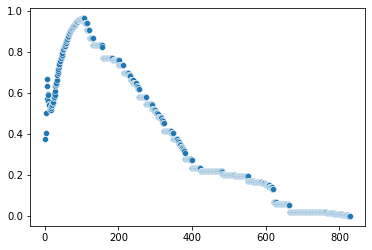

In [98]:
import seaborn as sns
sns.scatterplot(x=scores.keys(), y=scores.values()) # Somewhere around 180

In [99]:
# choose a n_cluster value
agg = AgglomerativeClustering(n_clusters=180, affinity='euclidean', linkage='ward')
agg = agg.fit(topOnlyDF)

In [100]:
topOnlyDF["clusters"] = agg.labels_
topOnlyDF.reset_index(inplace=True)
topOnlyDF.head()

item_id,user_id,50,100,258,clusters
0,0,5.0,-1.0,-1.0,2
1,1,5.0,5.0,5.0,18
2,2,5.0,5.0,3.0,20
3,3,-1.0,-1.0,2.0,31
4,4,5.0,-1.0,5.0,1


In [101]:
# Let's look at a specific user right now
user = 365
topOnlyDF[topOnlyDF['user_id'] == user]

item_id,user_id,50,100,258,clusters
325,365,-1.0,5.0,4.0,77


In [102]:
# Now, let's get users in same cluster
cluster = 77
user_ids = topOnlyDF[topOnlyDF['clusters'] == cluster]
user_ids

item_id,user_id,50,100,258,clusters
24,24,-1.0,5.0,4.0,77
176,195,-1.0,5.0,4.0,77
325,365,-1.0,5.0,4.0,77
439,491,-1.0,5.0,4.0,77
522,583,-1.0,5.0,4.0,77
562,627,-1.0,5.0,4.0,77
642,725,-1.0,5.0,4.0,77
698,788,-1.0,5.0,4.0,77


In [103]:
reviews[reviews["user_id"] == 24]

,user_id,item_id,rating
938,24,64,5
1041,24,191,5
1340,24,763,5
1709,24,367,2
3424,24,153,4
...,...,...,...
94160,24,518,4
94267,24,58,3
95862,24,276,5
96776,24,151,5


In [80]:
u365 = reviews[reviews["user_id"] == 365]

In [104]:
u365[u365['item_id'] == 64]

,user_id,item_id,rating


In [105]:
movies[movies["item_id"] == 64]

,item_id,title
63,64,"Shawshank Redemption, The (1994)"
